In [1]:
# SPARQL query to pull data and media from Wikidata via linked IDs.

from IPython.display import Image, display
import json
import pandas
import pathlib
import pydash
import requests

def value_extract(row, column):

    ''' Extract dictionary values. '''
    
    return pydash.get(row[column], 'value')

def sparql_query(query, service):

    ''' Send sparql request, and formulate results into a dataframe. '''

    response = requests.get(service, params={'format': 'json', 'query': query}, timeout=120)
    results = pydash.get(response.json(), 'results.bindings')
    data_frame = pandas.DataFrame.from_dict(results)
    for column in data_frame.columns:
        data_frame[column] = data_frame.apply(value_extract, column=column, axis=1)
    
    return data_frame

acmi_creator_id = '73769' # ACMI ID for Jacki Weaver.

query = '''
    select ?acmi_creator ?wikidata_creator ?wikidata_creatorLabel ?dob ?pobLabel ?dod ?podLabel ?article ?image ?imageLicense  
    where {
        values ?acmi_creator {"creators/'''+acmi_creator_id+'''"}
        ?wikidata_creator wdt:P7003 ?acmi_creator.
        optional { ?wikidata_creator wdt:P569 ?dob } .
        optional { ?wikidata_creator wdt:P19 ?pob } .
        optional { ?wikidata_creator wdt:P570 ?dod } .
        optional { ?wikidata_creator wdt:P20 ?pod } .
        optional { ?wikidata_creator wdt:P18 ?image .
            bind(strafter(wikibase:decodeUri(str(?image)), "http://commons.wikimedia.org/wiki/Special:FilePath/") AS ?fileTitle)
            service wikibase:mwapi {
                bd:serviceParam wikibase:endpoint "commons.wikimedia.org";
                wikibase:api "Generator";
                wikibase:limit "once";
                mwapi:generator "allpages";
                mwapi:gapfrom ?fileTitle;
                mwapi:gapnamespace 6; # NS_FILE
                mwapi:gaplimit 1;
                mwapi:prop "imageinfo";
                mwapi:iiprop "extmetadata" .
                ?imageLicense wikibase:apiOutput "imageinfo/ii/extmetadata/License/@value".
            }
        }
        optional { ?article schema:about ?wikidata_creator .
            ?article schema:isPartOf <https://en.wikipedia.org/> } .
        service wikibase:label { bd:serviceParam wikibase:language "en". }
    } '''

data = sparql_query(query, 'https://query.wikidata.org/sparql').to_dict('records')
if len(data):
    datum = data[0]
    print(json.dumps(datum, indent=4))

{
    "wikidata_creator": "http://www.wikidata.org/entity/Q241897",
    "article": "https://en.wikipedia.org/wiki/Jacki_Weaver",
    "image": "http://commons.wikimedia.org/wiki/Special:FilePath/Jacki%20Weaver%20-%20Flickr%20-%20Eva%20Rinaldi%20Celebrity%20and%20Live%20Music%20Photographer%20%281%29.jpg",
    "imageLicense": "cc-by-sa-2.0",
    "acmi_creator": "creators/73769",
    "dob": "1947-05-25T00:00:00Z",
    "wikidata_creatorLabel": "Jacki Weaver",
    "pobLabel": "Sydney"
}


In [2]:
print(f"{datum['wikidata_creatorLabel']} (born {datum['pobLabel']}, {datum['dob'][:4]})")

Jacki Weaver (born Sydney, 1947)


In [3]:
if datum['article']:
    wikipedia_query = requests.get(f"https://en.wikipedia.org/api/rest_v1/page/summary/{pathlib.Path(datum['article']).name}")
    wikipedia_query = json.loads(wikipedia_query.text)
    print(wikipedia_query['extract'])

Jacqueline Ruth Weaver is an Australian theatre, film, and television actress. Weaver emerged in the 1970s as a symbol of the Australian New Wave through her work in Ozploitation films such as Stork (1971), Alvin Purple (1973), and Petersen (1974). She later starred in Picnic at Hanging Rock (1975), Caddie (1976), Squizzy Taylor (1982), and a number of made-for-television movies, miniseries, and Australian productions of revered plays such as Death of a Salesman and A Streetcar Named Desire.


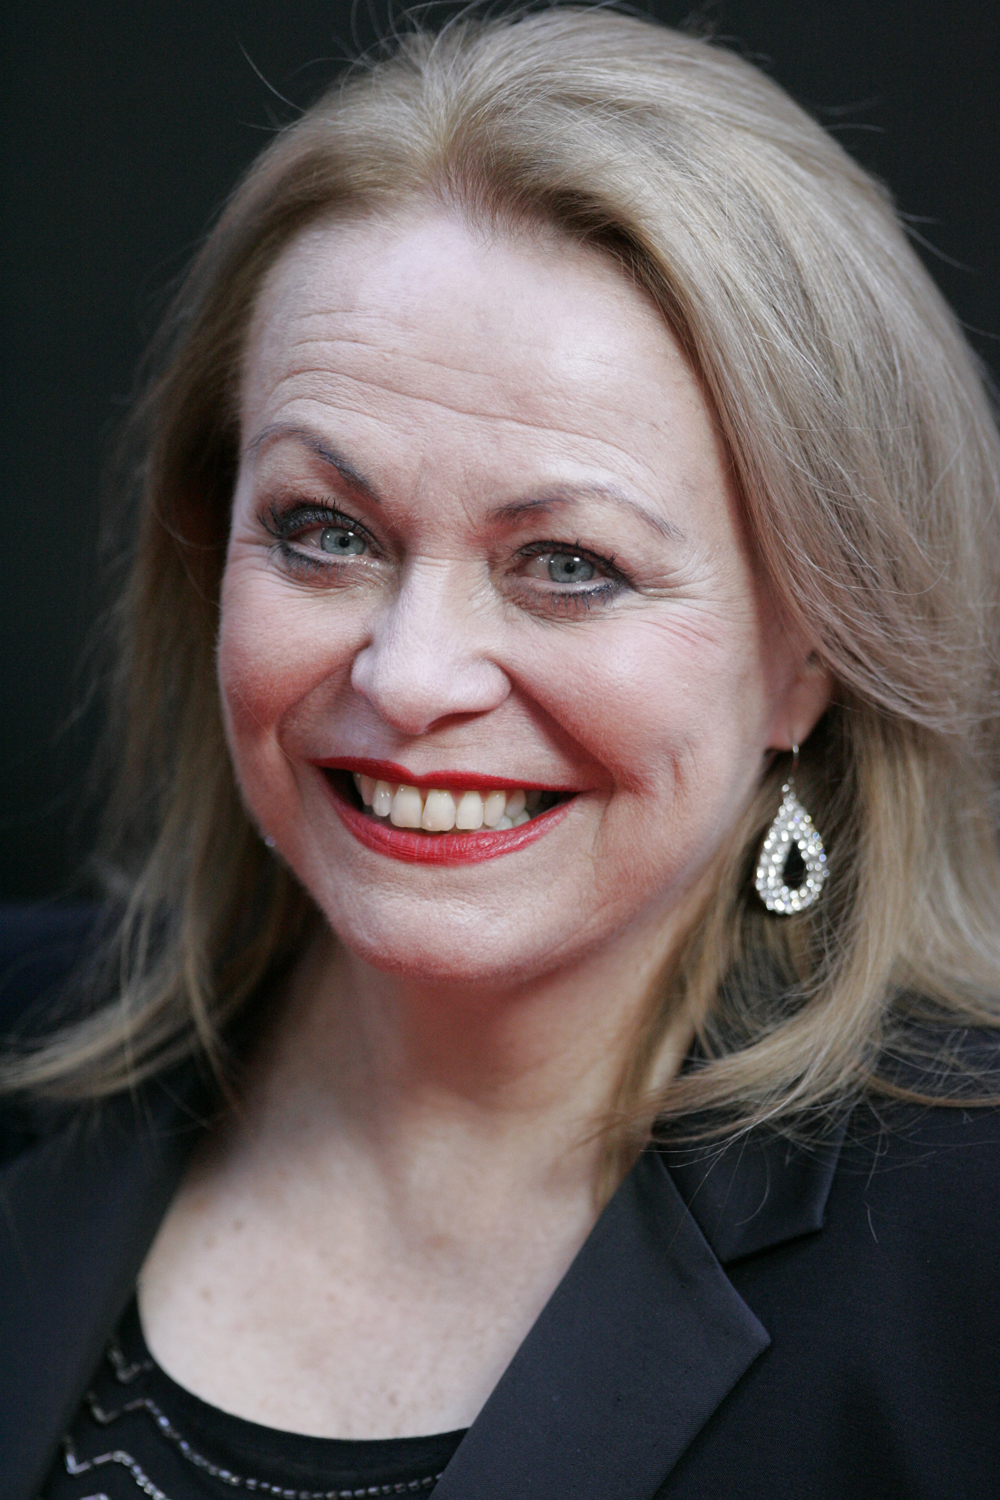

In [4]:
if datum['image']:
    display(Image(datum['image'], width=300, height=300))